In [1]:
# from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

import os

import cv2


tf.compat.v1.disable_eager_execution()

In [2]:
model = VGG16(weights='imagenet')

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-03 22:24:25.800486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-03 22:24:25.800581: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-03 22:24:25.808762: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-03 22:24:25.808846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 22:24:25.823255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-03 22:24:26.007004: I tensorflow/core/grappler/o

In [3]:
folder_dir = os.getcwd()
# folder_dir = './code/chap05'
img_path = folder_dir + '/datasets/creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
print(f"x.shape (img_to_array)    : {x.shape}")
print()

x = np.expand_dims(x, axis=0)
print(f"x.shape (np.expand_dims)  : {x.shape}")
print(f"np.max(x) : {np.max(x)}")
print(f"np.min(x) : {np.min(x)}")
print()

x = preprocess_input(x)
print(f"x.shape (preprocess_input): {x.shape}")
print(f"np.max(x) : {np.max(x)}")
print(f"np.min(x) : {np.min(x)}")
print()

x.shape (img_to_array)    : (224, 224, 3)

x.shape (np.expand_dims)  : (1, 224, 224, 3)
np.max(x) : 255.0
np.min(x) : 0.0

x.shape (preprocess_input): (1, 224, 224, 3)
np.max(x) : 143.06100463867188
np.min(x) : -123.68000030517578



In [4]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])
print(f"np.argmax(preds[0]): {np.argmax(preds[0])}")
# np.argmax(preds[0]): 386

/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2022-04-03 22:24:26.175040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Predicted: [('n02504458', 'African_elephant', 0.90942186), ('n01871265', 'tusker', 0.086182125), ('n02504013', 'Indian_elephant', 0.00435457)]
np.argmax(preds[0]): 386


In [5]:
# 예측 벡터의 '아프리카 코끼리' 항목
african_elephant_output = model.output[:, 386]

# VGG16의 마지막 합성곱 층인 block5_conv3 층의 특성 맵
last_conv_layer = model.get_layer('block5_conv3')

# block5_conv3의 특성 맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트
grads = backend.gradients(african_elephant_output, last_conv_layer.output)[0]

# 특성 맵 채널별 그래디언트 평균 값이 담긴 (512,) 크기의 벡터
pooled_grads = backend.mean(grads, axis=(0, 1, 2))

# 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구합니다
iterate = backend.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 두 마리 코끼리가 있는 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻습니다
pooled_grads_value, conv_layer_output_value = iterate([x])

# "아프리카 코끼리" 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다
heatmap = np.mean(conv_layer_output_value, axis=-1)

2022-04-03 22:24:26.321845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


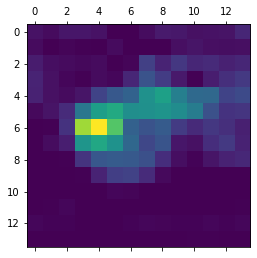

In [6]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [7]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

cv2.imwrite('./datasets/elephant_cam.jpg', superimposed_img)

True